In [1]:
import nibabel as nib
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import config
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data

In [2]:
normalized_scan_100206 = np.load("normalized_scan_100206_full.npy")

In [6]:
single_normalized_scan_100206 = normalized_scan_100206[:,0:16]

In [4]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals') * 1e-3

In [11]:
single_bvals_100206 = bvals_all_100206[0:16]

In [12]:
single_big_b_indices_100206 = np.where(single_bvals_100206 != 0.005)[0]

In [13]:
single_normalized_scan_100206_no_b5 = single_normalized_scan_100206[:, single_big_b_indices_100206]

In [14]:
single_normalized_scan_100206_no_b5.shape

(935442, 15)

In [15]:
single_bvals_100206_no_5 = single_bvals_100206[single_big_b_indices_100206]

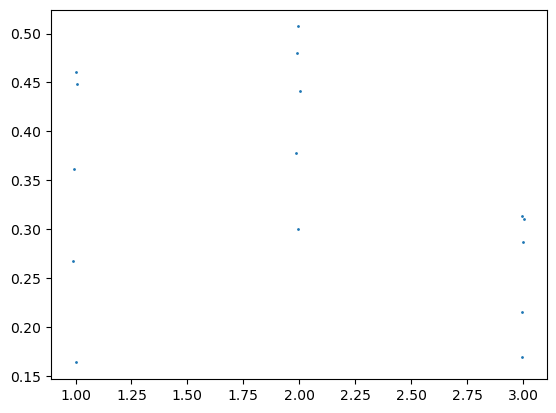

In [16]:
plt.plot(single_bvals_100206_no_5, single_normalized_scan_100206_no_b5[42,:], "o", markersize = 1)

In [15]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [16]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [20]:
n_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvecs')
single_n_100206 = n_all_100206[:, 0:80]
single_n_100206_no_5 = single_n_100206[:,single_big_b_indices_100206].T
print(single_n_100206_no_5.shape)

single_b_values_100206 = torch.FloatTensor(single_bvals_100206_no_5)
single_gradient_directions_100206 = torch.FloatTensor(single_n_100206_no_5)

net = BallStickNet(single_gradient_directions_100206, single_b_values_100206)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

(15, 3)


In [21]:
batch_size = 128
num_batches = len(single_normalized_scan_100206_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(single_normalized_scan_100206_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [22]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.89it/s]


Loss: 767.6157261505723
Average Loss: 0.10503772935831586
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:19<00:00, 366.60it/s]


Loss: 547.2580349850468
Average Loss: 0.0748847885858028
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:19<00:00, 369.72it/s]


Loss: 497.1339495573193
Average Loss: 0.06802599200291726
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:19<00:00, 375.16it/s]


Loss: 490.2672358690761
Average Loss: 0.06708637600835743
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 488.57it/s]


Loss: 488.0878690960817
Average Loss: 0.06678815942748792
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 483.07it/s]


Loss: 486.60670693870634
Average Loss: 0.06658548261339714
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 478.88it/s]


Loss: 485.33138793567196
Average Loss: 0.06641097262392884
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 476.86it/s]


Loss: 484.1633482812904
Average Loss: 0.06625114234828823
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 475.95it/s]


Loss: 483.08206230029464
Average Loss: 0.06610318312811914
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 481.70it/s]


Loss: 482.0728445192799
Average Loss: 0.06596508545693486
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  3%|█▌                                                        | 201/7308 [00:01<00:32, 220.56it/s]

X_batch: 
torch.Size([128, 15])
tensor([[0.3656, 0.2361, 0.3439,  ..., 0.5445, 0.2161, 0.2790],
        [0.4662, 0.2314, 0.1727,  ..., 0.4101, 0.2899, 0.1244],
        [0.4325, 0.2615, 0.1196,  ..., 0.4723, 0.2169, 0.2013],
        ...,
        [0.3270, 0.2292, 0.1428,  ..., 0.3629, 0.1734, 0.1362],
        [0.4706, 0.5659, 0.3814,  ..., 0.5927, 0.2909, 0.4363],
        [0.4454, 0.4088, 0.2183,  ..., 0.4243, 0.3378, 0.2057]])
X_pred: 
torch.Size([128, 15])
tensor([[0.4788, 0.3137, 0.2446,  ..., 0.4710, 0.3221, 0.2889],
        [0.4398, 0.2561, 0.1825,  ..., 0.4332, 0.2622, 0.2148],
        [0.4372, 0.2325, 0.1482,  ..., 0.4319, 0.2367, 0.1714],
        ...,
        [0.3653, 0.1785, 0.1176,  ..., 0.3613, 0.1822, 0.1352],
        [0.6175, 0.4492, 0.3369,  ..., 0.6026, 0.4600, 0.4090],
        [0.4823, 0.3059, 0.2270,  ..., 0.4741, 0.3134, 0.2699]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 462.44it/s]


Loss: 481.33576670335606
Average Loss: 0.0658642264235572
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 468.58it/s]


Loss: 480.6036658324301
Average Loss: 0.06576404841713603
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 476.91it/s]


Loss: 480.1414667009376
Average Loss: 0.06570080277790608
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 481.04it/s]


Loss: 479.72311639320105
Average Loss: 0.06564355725139588
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 481.64it/s]


Loss: 479.2986975479871
Average Loss: 0.06558548132840546
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 480.78it/s]


Loss: 478.9508120745886
Average Loss: 0.06553787795218782
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 483.12it/s]


Loss: 478.60875305952504
Average Loss: 0.06549107184722565
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 484.79it/s]


Loss: 478.3353054760955
Average Loss: 0.06545365427970656
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 483.79it/s]


Loss: 478.044067094801
Average Loss: 0.06541380228445552
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 479.20it/s]


Loss: 477.8346797830891
Average Loss: 0.0653851504902968
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 466.47it/s]


Loss: 477.63740035751835
Average Loss: 0.06535815549500798
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 485.51it/s]


Loss: 477.45685739978217
Average Loss: 0.06533345065678464
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 477.85it/s]


Loss: 477.2967215317767
Average Loss: 0.06531153825010629
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 479.42it/s]


Loss: 477.13239898276515
Average Loss: 0.06528905295330667
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 507.38it/s]


Loss: 476.9839189387858
Average Loss: 0.06526873548697124
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 507.83it/s]


Loss: 476.8412831136957
Average Loss: 0.06524921772218058
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 507.53it/s]


Loss: 476.7033499018289
Average Loss: 0.0652303434457894
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 507.96it/s]


Loss: 476.57525906991214
Average Loss: 0.0652128159646842
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 506.00it/s]


Loss: 476.4610352704767
Average Loss: 0.06519718599760217
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 506.13it/s]


Loss: 476.3395403770264
Average Loss: 0.06518056108060022
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 509.11it/s]


Loss: 476.2421799057629
Average Loss: 0.06516723862968841
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 503.98it/s]


Loss: 476.1378804373089
Average Loss: 0.06515296667177188
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 505.57it/s]


Loss: 476.0229819698725
Average Loss: 0.06513724438558736
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 505.67it/s]


Loss: 475.9117197599262
Average Loss: 0.06512201967158268
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 507.72it/s]


Loss: 475.79287057439797
Average Loss: 0.06510575678357935
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 507.78it/s]


Loss: 475.6529206468258
Average Loss: 0.0650866065471847
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 506.99it/s]


Loss: 475.4978744597174
Average Loss: 0.06506539059383107
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 508.79it/s]


Loss: 475.34183788415976
Average Loss: 0.06504403911934316
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 486.29it/s]


Loss: 475.20164698245935
Average Loss: 0.06502485590892985
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 456.49it/s]


Loss: 475.0659172295127
Average Loss: 0.06500628314580087
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 454.87it/s]


Loss: 474.9218758752104
Average Loss: 0.0649865730535318
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 458.47it/s]


Loss: 474.82178616081364
Average Loss: 0.06497287714296848
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 453.64it/s]


Loss: 474.67520371614955
Average Loss: 0.06495281933718522
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 464.24it/s]


Loss: 474.54113061307
Average Loss: 0.06493447326396688
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 497.36it/s]


Loss: 474.40755139593966
Average Loss: 0.06491619477229607
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 501.16it/s]


Loss: 474.26220453949645
Average Loss: 0.0648963060398873
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 498.67it/s]


Loss: 474.10509735392407
Average Loss: 0.06487480806703942
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 502.53it/s]


Loss: 473.96123976889066
Average Loss: 0.0648551231210852
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 501.01it/s]


Loss: 473.80419251532294
Average Loss: 0.0648336333491137
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 501.17it/s]


Loss: 473.659364876803
Average Loss: 0.06481381566458716
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 497.70it/s]


Loss: 473.5591671296861
Average Loss: 0.06480010497122142
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 498.03it/s]


Loss: 473.45325380261056
Average Loss: 0.06478561217879181
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 496.48it/s]


Loss: 473.37519933702424
Average Loss: 0.06477493149110895
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 500.00it/s]


Loss: 473.26172225386836
Average Loss: 0.06475940370195243
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 496.14it/s]


Loss: 473.2001287098974
Average Loss: 0.06475097546659789
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 501.06it/s]


Loss: 473.11603010399267
Average Loss: 0.06473946772085286
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 501.05it/s]


Loss: 473.0324572431855
Average Loss: 0.06472803191614471
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 503.06it/s]


Loss: 472.9505311443936
Average Loss: 0.06471682144832973
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 500.42it/s]


Loss: 472.8825332901906
Average Loss: 0.06470751687057891
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 501.70it/s]


Loss: 472.7815458911937
Average Loss: 0.06469369812413707
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 501.69it/s]


Loss: 472.7077706679702
Average Loss: 0.06468360299233308
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 500.49it/s]


Loss: 472.62617061519995
Average Loss: 0.06467243713946359
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 499.13it/s]


Loss: 472.53116078372113
Average Loss: 0.06465943634150535
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 493.41it/s]


Loss: 472.44614336057566
Average Loss: 0.06464780286816854
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 500.10it/s]


Loss: 472.367684654193
Average Loss: 0.06463706686565313
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 495.17it/s]


Loss: 472.2619236286264
Average Loss: 0.06462259491360514
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 497.31it/s]


Loss: 472.1804856476374
Average Loss: 0.06461145123804563
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 497.02it/s]


Loss: 472.0658130564261
Average Loss: 0.06459575985993789
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 500.15it/s]


Loss: 471.9624543925747
Average Loss: 0.06458161663828335
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 495.45it/s]


Loss: 471.85886173928156
Average Loss: 0.06456744139836912
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 501.43it/s]


Loss: 471.76652671862394
Average Loss: 0.06455480661174383
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 495.09it/s]


Loss: 471.6364092095755
Average Loss: 0.06453700180755001
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 502.04it/s]


Loss: 471.53807804058306
Average Loss: 0.0645235465299101
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 500.37it/s]


Loss: 471.4487977833487
Average Loss: 0.06451132974594262
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 497.92it/s]


Loss: 471.34991059661843
Average Loss: 0.06449779838486842
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 502.02it/s]


Loss: 471.27002007490955
Average Loss: 0.06448686645797887
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 499.85it/s]


Loss: 471.17821337631904
Average Loss: 0.06447430396501355
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 494.26it/s]


Loss: 471.1631904405076
Average Loss: 0.06447224828140498
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 502.76it/s]


Loss: 471.05684471759014
Average Loss: 0.06445769632150933
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 495.40it/s]


Loss: 470.98959856363945
Average Loss: 0.06444849460367261
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 501.65it/s]


Loss: 470.9248403196689
Average Loss: 0.06443963332234112
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 498.92it/s]


Loss: 470.9276646291837
Average Loss: 0.0644400197905287
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 490.59it/s]


Loss: 470.834145341767
Average Loss: 0.06442722295317009
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 490.21it/s]


Loss: 470.78885731031187
Average Loss: 0.0644210259045309
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 477.19it/s]


Loss: 470.7513029659167
Average Loss: 0.06441588710535258
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 490.66it/s]


Loss: 470.6995338194538
Average Loss: 0.06440880320463242
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 493.20it/s]


Loss: 470.66205208026804
Average Loss: 0.0644036743404855
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 501.03it/s]


Loss: 470.6047879026737
Average Loss: 0.06439583851979662
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 501.01it/s]


Loss: 470.596965654986
Average Loss: 0.06439476815202326
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 500.64it/s]


Loss: 470.5384904053062
Average Loss: 0.06438676661265821
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 502.73it/s]


Loss: 470.49345653364435
Average Loss: 0.06438060434231586
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 499.90it/s]


Loss: 470.45239468989894
Average Loss: 0.06437498558975081
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 502.02it/s]


Loss: 470.4046157405246
Average Loss: 0.06436844769301103
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 499.83it/s]


Loss: 470.3784385488834
Average Loss: 0.06436486570181765
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 499.72it/s]


Loss: 470.3405808398966
Average Loss: 0.0643596853913378
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 500.01it/s]


Loss: 470.2971933528315
Average Loss: 0.06435374840624405
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 499.89it/s]


Loss: 470.2457137927413
Average Loss: 0.06434670413146433
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 500.91it/s]


Loss: 470.21745968214236
Average Loss: 0.06434283794227455
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 500.92it/s]


Loss: 470.17565487883985
Average Loss: 0.06433711752584015
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 498.19it/s]


Loss: 470.1400574569125
Average Loss: 0.0643322465047773
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 500.90it/s]


Loss: 470.096554703312
Average Loss: 0.06432629374703229
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 496.78it/s]


Loss: 470.05670028715394
Average Loss: 0.06432084021444362
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 499.38it/s]


Loss: 470.01707041892223
Average Loss: 0.06431541740817218
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 499.42it/s]


Loss: 469.9808739675209
Average Loss: 0.06431046441810631
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 495.85it/s]


Loss: 469.9307290802244
Average Loss: 0.06430360277507176
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 494.71it/s]


Loss: 469.9070670919027
Average Loss: 0.06430036495510437
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 496.47it/s]


Loss: 469.8794158913661
Average Loss: 0.06429658126592311
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 497.18it/s]


Loss: 469.8165393723175
Average Loss: 0.06428797747294984
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 497.55it/s]


Loss: 469.79549765517004
Average Loss: 0.06428509820130952
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 500.70it/s]


Loss: 469.7693156392779
Average Loss: 0.06428151554998329
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 497.90it/s]


Loss: 469.710818907246
Average Loss: 0.06427351107105173
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 498.53it/s]


Loss: 469.6969382725656
Average Loss: 0.06427161169575336
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 487.63it/s]


Loss: 469.6431373809464
Average Loss: 0.06426424977845463
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 495.53it/s]


Loss: 469.6272959958296
Average Loss: 0.06426208210123559
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 496.09it/s]


Loss: 469.58532409672625
Average Loss: 0.06425633882002275
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 497.93it/s]


Loss: 469.548974591773
Average Loss: 0.06425136488666845
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 496.16it/s]


Loss: 469.5213953675702
Average Loss: 0.06424759104646555
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 499.54it/s]


Loss: 469.4794604331255
Average Loss: 0.06424185282336145
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 497.45it/s]


Loss: 469.44619572907686
Average Loss: 0.06423730100288408
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 496.24it/s]


Loss: 469.4095486646984
Average Loss: 0.06423228635258599
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 497.92it/s]


Loss: 469.399113423191
Average Loss: 0.06423085843229215
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 500.15it/s]


Loss: 469.3550445009023
Average Loss: 0.06422482820209391
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 481.77it/s]


Loss: 469.3200686716009
Average Loss: 0.06422004223749328
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 485.27it/s]


Loss: 469.2736990619451
Average Loss: 0.06421369718964766
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 496.07it/s]


Loss: 469.2404076086823
Average Loss: 0.06420914170890563
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 498.49it/s]


Loss: 469.21134099154733
Average Loss: 0.06420516433929219
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 485.59it/s]


Loss: 469.1813200991601
Average Loss: 0.06420105639014231
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 483.17it/s]


Loss: 469.1419696882367
Average Loss: 0.06419567182378719
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 480.47it/s]


Loss: 469.10958115104586
Average Loss: 0.06419123989477912
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 488.04it/s]


Loss: 469.07378616416827
Average Loss: 0.06418634183965083
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:14<00:00, 496.92it/s]


Loss: 469.04910601326264
Average Loss: 0.06418296469803812
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:20<00:00, 352.26it/s]


Loss: 469.00508298608474
Average Loss: 0.06417694074795906
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 437.28it/s]


Loss: 468.9600711299572
Average Loss: 0.06417078149014192
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 455.29it/s]


Loss: 468.9389140603598
Average Loss: 0.06416788643409412
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 467.39it/s]


Loss: 468.90145095135085
Average Loss: 0.06416276011923247
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 473.63it/s]


Loss: 468.86591837578453
Average Loss: 0.06415789797150856
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 466.16it/s]


Loss: 468.84850405110046
Average Loss: 0.06415551505899021
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 467.02it/s]


Loss: 468.80593363102525
Average Loss: 0.06414968987835594
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 467.78it/s]


Loss: 468.7665798268281
Average Loss: 0.06414430484767762
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 468.31it/s]


Loss: 468.744744698517
Average Loss: 0.0641413170085546
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 470.88it/s]


Loss: 468.6846236397978
Average Loss: 0.06413309026269812
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 466.47it/s]


Loss: 468.70553285465576
Average Loss: 0.0641359514032096
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 468.09it/s]


Loss: 468.66564700519666
Average Loss: 0.06413049356940294
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 465.49it/s]


Loss: 468.49306836281903
Average Loss: 0.0641068785389736
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 461.80it/s]


Loss: 468.5988847934641
Average Loss: 0.06412135807244992
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 462.73it/s]


Loss: 468.5587073569186
Average Loss: 0.06411586033893249
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 460.37it/s]


Loss: 468.5239417066332
Average Loss: 0.06411110313445993
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 462.14it/s]


Loss: 468.5166845351923
Average Loss: 0.06411011008965412
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 464.29it/s]


Loss: 468.49164037243463
Average Loss: 0.0641066831379905
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 459.98it/s]


Loss: 468.436909311451
Average Loss: 0.06409919393971689
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 458.32it/s]


Loss: 468.4242682289332
Average Loss: 0.06409746418020433
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 463.68it/s]


Loss: 468.3718755070586
Average Loss: 0.06409029495170479
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 462.33it/s]


Loss: 468.37727098632604
Average Loss: 0.06409103324936043
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 463.82it/s]


Loss: 468.2991833528504
Average Loss: 0.06408034802310487
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 462.61it/s]


Loss: 468.31291115819477
Average Loss: 0.06408222648579567
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 462.19it/s]


Loss: 468.24762924574316
Average Loss: 0.0640732935475839
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 456.08it/s]


Loss: 468.2469669270795
Average Loss: 0.06407320291831958
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 455.19it/s]


Loss: 468.2018590073567
Average Loss: 0.06406703051551131
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 457.21it/s]


Loss: 468.1635405640118
Average Loss: 0.06406178715982647
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 462.25it/s]


Loss: 468.1378724621609
Average Loss: 0.06405827483061863
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 465.43it/s]


Loss: 468.11368976929225
Average Loss: 0.06405496575934486
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 451.69it/s]


Loss: 468.0757180196233
Average Loss: 0.06404976984395502
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.20it/s]


Loss: 468.03078037756495
Average Loss: 0.06404362074131978
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 316.33it/s]


Loss: 468.0022856404539
Average Loss: 0.06403972162567788
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:19<00:00, 381.37it/s]


Loss: 467.99939212948084
Average Loss: 0.06403932568821577
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:18<00:00, 389.74it/s]


Loss: 467.93019512528554
Average Loss: 0.06402985702316441
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:18<00:00, 402.50it/s]


Loss: 467.90707134315744
Average Loss: 0.06402669284936473
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:18<00:00, 402.04it/s]


Loss: 467.877177557908
Average Loss: 0.06402260229309086
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:18<00:00, 402.36it/s]


Loss: 467.84796421485953
Average Loss: 0.0640186048460399
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:18<00:00, 405.24it/s]


Loss: 467.7964272443205
Average Loss: 0.06401155271542426
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:17<00:00, 408.16it/s]


Loss: 467.78703412087634
Average Loss: 0.06401026739475593
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:17<00:00, 406.45it/s]


Loss: 467.7497528619133
Average Loss: 0.06400516596358967
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:17<00:00, 407.97it/s]


Loss: 467.7010110390838
Average Loss: 0.0639984963107668
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:17<00:00, 406.98it/s]


Loss: 467.6657019772101
Average Loss: 0.06399366474783937
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:17<00:00, 406.39it/s]


Loss: 467.61469437438063
Average Loss: 0.0639866850539656
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:17<00:00, 406.42it/s]


Loss: 467.6104509513825
Average Loss: 0.06398610439947763
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:17<00:00, 409.56it/s]


Loss: 467.54067355929874
Average Loss: 0.06397655631626967
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:17<00:00, 406.28it/s]


Loss: 467.5224847176578
Average Loss: 0.06397406742168278
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:17<00:00, 408.61it/s]


Loss: 467.4949585259892
Average Loss: 0.06397030083825797
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:17<00:00, 407.82it/s]


Loss: 467.4419297198765
Average Loss: 0.06396304457031698
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:17<00:00, 409.42it/s]


Loss: 467.4194322542753
Average Loss: 0.06395996609938086
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:17<00:00, 407.45it/s]


Loss: 467.37142696534283
Average Loss: 0.0639533972311635
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:17<00:00, 406.31it/s]


Loss: 467.319370953599
Average Loss: 0.06394627407684715
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:18<00:00, 405.76it/s]


Loss: 467.30653591337614
Average Loss: 0.06394451777687139
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:18<00:00, 402.60it/s]


Loss: 467.2487387987785
Average Loss: 0.06393660903103154
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:18<00:00, 404.36it/s]


Loss: 467.2207848846447
Average Loss: 0.06393278391962845
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:18<00:00, 405.00it/s]


Loss: 467.1788963628933
Average Loss: 0.06392705204746761
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:17<00:00, 407.33it/s]


Loss: 467.1232864782214
Average Loss: 0.0639194425941737
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:18<00:00, 400.08it/s]


Loss: 467.0987078153994
Average Loss: 0.0639160793398193
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:18<00:00, 387.73it/s]


Loss: 467.08129772823304
Average Loss: 0.06391369700714737
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:18<00:00, 385.46it/s]


Loss: 467.00287970830686
Average Loss: 0.06390296657201791
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:18<00:00, 386.22it/s]


Loss: 466.97302808729
Average Loss: 0.06389888178534346
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:18<00:00, 385.88it/s]


Loss: 466.910199749982
Average Loss: 0.06389028458538341
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:18<00:00, 393.35it/s]


Loss: 466.90623317216523
Average Loss: 0.06388974181337784
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:18<00:00, 395.50it/s]


Loss: 466.8421864716802
Average Loss: 0.06388097789705531
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:18<00:00, 392.13it/s]


Loss: 466.79468997218646
Average Loss: 0.06387447864972448
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:19<00:00, 372.07it/s]


Loss: 466.7610335366335
Average Loss: 0.06386987322614032
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 467.43it/s]


Loss: 466.71202842355706
Average Loss: 0.06386316754564272
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 468.69it/s]


Loss: 466.6522822023835
Average Loss: 0.06385499209118549
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 475.59it/s]


Loss: 466.6350447810255
Average Loss: 0.06385263338547147
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 476.96it/s]


Loss: 466.5793195879087
Average Loss: 0.06384500815379156
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 468.11it/s]


Loss: 466.535878815921
Average Loss: 0.06383906387738383
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 477.45it/s]


Loss: 466.5114924549125
Average Loss: 0.06383572693690648
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 483.94it/s]


Loss: 466.46538830408826
Average Loss: 0.06382941821347678
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 478.10it/s]


Loss: 466.2792378300801
Average Loss: 0.06380394606322935
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 483.38it/s]


Loss: 466.389889275888
Average Loss: 0.06381908720250246
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 480.84it/s]


Loss: 466.344610348111
Average Loss: 0.06381289139957731
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 484.39it/s]


Loss: 466.29682876123115
Average Loss: 0.06380635314193092
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 480.11it/s]


Loss: 466.2480958190281
Average Loss: 0.0637996847043005
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 484.17it/s]


Loss: 466.2343508582562
Average Loss: 0.06379780389412373
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 479.54it/s]


Loss: 466.17087787739
Average Loss: 0.06378911848349617
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 479.79it/s]


Loss: 466.13450486632064
Average Loss: 0.06378414133365089
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 478.49it/s]


Loss: 466.10506285750307
Average Loss: 0.06378011259681213
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 482.70it/s]


Loss: 466.0680888979696
Average Loss: 0.06377505321537624
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 477.62it/s]


Loss: 466.02524626161903
Average Loss: 0.06376919078566215
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 479.74it/s]


Loss: 466.0130907765124
Average Loss: 0.06376752747352386
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 482.36it/s]


Loss: 465.9793325222563
Average Loss: 0.06376290811744065
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 484.45it/s]


Loss: 465.9195840517059
Average Loss: 0.0637547323551869
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 482.17it/s]


Loss: 465.89121886738576
Average Loss: 0.06375085096707522
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 479.08it/s]


Loss: 465.8620210306253
Average Loss: 0.06374685564184802
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 465.08it/s]


Loss: 465.8480938079301
Average Loss: 0.06374494989161605
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 459.05it/s]


Loss: 465.81138127855957
Average Loss: 0.0637399262833278
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 474.68it/s]


Loss: 465.8012117871549
Average Loss: 0.06373853472730637
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 482.95it/s]


Loss: 465.77800193754956
Average Loss: 0.06373535877634778
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 480.96it/s]


Loss: 465.7373105704319
Average Loss: 0.0637297907184499
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 484.32it/s]


Loss: 465.7094738497399
Average Loss: 0.0637259816433689
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 482.79it/s]


Loss: 465.6769766462967
Average Loss: 0.06372153484486819
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 480.58it/s]


Loss: 465.651127174031
Average Loss: 0.06371799769759592
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 481.73it/s]


Loss: 465.6298881242983
Average Loss: 0.06371509142368614
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 482.44it/s]


Loss: 465.60546596325
Average Loss: 0.06371174958446224
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 479.10it/s]


Loss: 465.60359831457026
Average Loss: 0.06371149402224552
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 461.76it/s]


Loss: 465.5819864622317
Average Loss: 0.06370853673539022
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 469.80it/s]


Loss: 465.55900895386003
Average Loss: 0.06370539257715654
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 471.97it/s]


Loss: 465.5143267957028
Average Loss: 0.06369927843400422
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 470.77it/s]


Loss: 465.5378958794754
Average Loss: 0.06370250354125279
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 480.63it/s]


Loss: 465.5041663523298
Average Loss: 0.06369788811608235
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 481.87it/s]


Loss: 465.4588851733133
Average Loss: 0.06369169200510581
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 476.75it/s]


Loss: 465.43424536357634
Average Loss: 0.06368832038363113
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 483.35it/s]


Loss: 465.4095792816952
Average Loss: 0.0636849451671723
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 480.08it/s]


Loss: 465.40081941732205
Average Loss: 0.06368374649935989
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 483.19it/s]


Loss: 465.42974226293154
Average Loss: 0.06368770419580344
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 477.35it/s]


Loss: 465.38726232922636
Average Loss: 0.0636818913969932
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 482.07it/s]


Loss: 465.3414922221564
Average Loss: 0.06367562838288948
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 480.81it/s]


Loss: 465.3414934689645
Average Loss: 0.06367562855349815
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 480.61it/s]


Loss: 465.32644307566807
Average Loss: 0.06367356911270773
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 479.28it/s]


Loss: 465.3112187848892
Average Loss: 0.06367148587642162
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 482.93it/s]


Loss: 465.27760013658553
Average Loss: 0.0636668856235065
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 479.86it/s]


Loss: 465.25227176002227
Average Loss: 0.06366341978106489
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 481.44it/s]


Loss: 465.27358253346756
Average Loss: 0.06366633586938528
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 480.14it/s]


Loss: 465.23726519709453
Average Loss: 0.06366136633786187
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.80it/s]


Loss: 465.20948943542317
Average Loss: 0.06365756560419036
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.53it/s]


Loss: 465.1894655965734
Average Loss: 0.06365482561529466
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:19<00:00, 368.05it/s]


Loss: 465.17062727175653
Average Loss: 0.06365224784780467
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 459.24it/s]


Loss: 465.16787073388696
Average Loss: 0.06365187065324124
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 454.72it/s]


Loss: 465.15212075505406
Average Loss: 0.06364971548372388
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 454.90it/s]


Loss: 465.14069490879774
Average Loss: 0.0636481520126981
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 451.90it/s]


Loss: 465.1250550355762
Average Loss: 0.06364601190963003
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 456.33it/s]


Loss: 465.1029635812156
Average Loss: 0.06364298899578757
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 457.55it/s]


Loss: 465.0970178588759
Average Loss: 0.06364217540488176
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 460.17it/s]


Loss: 465.0872074600775
Average Loss: 0.06364083298577962
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 455.93it/s]


Loss: 465.0750400638208
Average Loss: 0.0636391680437631
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 457.33it/s]


Loss: 465.066643046448
Average Loss: 0.06363801902660755
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 458.20it/s]


Loss: 465.04285000334494
Average Loss: 0.06363476327358306
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 459.67it/s]


Loss: 465.0431564729661
Average Loss: 0.06363480520976547
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 458.18it/s]


Loss: 465.01994245359674
Average Loss: 0.06363162868823163
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 460.96it/s]


Loss: 465.0012434357777
Average Loss: 0.06362906998300188
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 460.10it/s]


Loss: 465.00163851329125
Average Loss: 0.06362912404396433
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 458.49it/s]


Loss: 464.9660085993819
Average Loss: 0.06362424857681745
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 455.63it/s]


Loss: 464.95138347148895
Average Loss: 0.06362224732778995
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 458.02it/s]


Loss: 464.9328983495943
Average Loss: 0.06361971789129643
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 455.54it/s]


Loss: 464.9596199495718
Average Loss: 0.06362337437733605
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 460.94it/s]


Loss: 464.91981951519847
Average Loss: 0.06361792823141742
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 459.48it/s]


Loss: 464.90582921612076
Average Loss: 0.0636160138500439
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 460.21it/s]


Loss: 464.9029361153953
Average Loss: 0.06361561796871856
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 461.89it/s]


Loss: 464.8836184546817
Average Loss: 0.06361297461065704
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 459.07it/s]


Loss: 464.87378507084213
Average Loss: 0.06361162904636591
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 459.15it/s]


Loss: 464.86797597236
Average Loss: 0.06361083415056924
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 453.33it/s]


Loss: 464.841167263221
Average Loss: 0.06360716574483045
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 461.82it/s]


Loss: 464.8420901601203
Average Loss: 0.0636072920306678
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 460.43it/s]


Loss: 464.81404694519006
Average Loss: 0.06360345469967023
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 456.93it/s]


Loss: 464.8051219317131
Average Loss: 0.06360223343345828
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 458.47it/s]


Loss: 464.79953631642275
Average Loss: 0.06360146911828445
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 436.08it/s]


Loss: 464.77874993509613
Average Loss: 0.06359862478586428
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 457.47it/s]


Loss: 464.7539322988596
Average Loss: 0.06359522883126158
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 451.02it/s]


Loss: 464.77300335885957
Average Loss: 0.06359783844538308
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 438.54it/s]


Loss: 464.757517013466
Average Loss: 0.06359571935050164
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 442.97it/s]


Loss: 464.73035768815316
Average Loss: 0.06359200296772759
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:17<00:00, 418.74it/s]


Loss: 464.71064865845256
Average Loss: 0.06358930605616482
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 461.37it/s]


Loss: 464.7122962663416
Average Loss: 0.06358953150880427
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 473.06it/s]


Loss: 464.68546716030687
Average Loss: 0.06358586031202886
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 463.45it/s]


Loss: 464.6671353196725
Average Loss: 0.06358335184998255
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 473.26it/s]


Loss: 464.6609531645663
Average Loss: 0.06358250590648143
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 475.52it/s]


Loss: 464.6421997474972
Average Loss: 0.0635799397574572
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 475.30it/s]


Loss: 464.6265191130806
Average Loss: 0.06357779407677622
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 473.82it/s]


Loss: 464.67208181717433
Average Loss: 0.06358402871061498
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 468.10it/s]


Loss: 464.6068243305199
Average Loss: 0.06357509911473999
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 470.04it/s]


Loss: 464.6107149363961
Average Loss: 0.06357563149102301
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 475.93it/s]


Loss: 464.57673749746755
Average Loss: 0.06357098214251061
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 458.18it/s]


Loss: 464.6151651130058
Average Loss: 0.06357624043691924
-----------------------------------------------------------------
Epoch: 299; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 466.43it/s]


Loss: 464.5498222594615
Average Loss: 0.06356729915975116
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 300; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 477.17it/s]


Loss: 464.56645063706674
Average Loss: 0.06356957452614487
-----------------------------------------------------------------
Epoch: 301; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 476.04it/s]


Loss: 464.52636738936417
Average Loss: 0.06356408968108432
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 302; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 465.02it/s]


Loss: 464.5307512998115
Average Loss: 0.06356468955936119
-----------------------------------------------------------------
Epoch: 303; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 477.83it/s]


Loss: 464.52830737945624
Average Loss: 0.0635643551422354
-----------------------------------------------------------------
Epoch: 304; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 476.70it/s]


Loss: 464.4872053540312
Average Loss: 0.0635587308913562
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 305; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 475.42it/s]


Loss: 464.5007742892485
Average Loss: 0.0635605876148397
-----------------------------------------------------------------
Epoch: 306; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 471.25it/s]


Loss: 464.47435259097256
Average Loss: 0.0635569721662524
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 307; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 461.77it/s]


Loss: 464.4512231738772
Average Loss: 0.0635538072213844
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 308; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 474.91it/s]


Loss: 464.44257888314314
Average Loss: 0.06355262436824619
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 309; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 470.97it/s]


Loss: 464.42611919902265
Average Loss: 0.06355037208525215
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 310; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 468.82it/s]


Loss: 464.4102318864316
Average Loss: 0.06354819812348543
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 311; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 462.03it/s]


Loss: 464.44231408974156
Average Loss: 0.06355258813488528
-----------------------------------------------------------------
Epoch: 312; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 467.61it/s]


Loss: 464.38839576533064
Average Loss: 0.06354521014851268
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 313; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 461.04it/s]


Loss: 464.42673942423426
Average Loss: 0.06355045695460239
-----------------------------------------------------------------
Epoch: 314; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 473.54it/s]


Loss: 464.3690006856341
Average Loss: 0.0635425561967206
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 315; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 473.15it/s]


Loss: 464.35493236547336
Average Loss: 0.06354063113922734
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 316; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 476.34it/s]


Loss: 464.34183986019343
Average Loss: 0.06353883960867453
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 317; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 474.45it/s]


Loss: 464.35838173376396
Average Loss: 0.0635411031381724
-----------------------------------------------------------------
Epoch: 318; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 475.02it/s]


Loss: 464.3319684059825
Average Loss: 0.06353748883497297
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 319; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 459.72it/s]


Loss: 464.3078375023324
Average Loss: 0.06353418685034652
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 320; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 467.85it/s]


Loss: 464.32516624592245
Average Loss: 0.06353655805226087
-----------------------------------------------------------------
Epoch: 321; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 471.20it/s]


Loss: 464.3011607131921
Average Loss: 0.06353327322293269
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 322; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 474.57it/s]


Loss: 464.28010398731567
Average Loss: 0.06353039189755277
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 323; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 460.69it/s]


Loss: 464.25983093492687
Average Loss: 0.06352761780718759
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 324; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 472.43it/s]


Loss: 464.26555234077387
Average Loss: 0.0635284007034447
-----------------------------------------------------------------
Epoch: 325; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 469.50it/s]


Loss: 464.23934281547554
Average Loss: 0.0635248142878319
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 326; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 473.12it/s]


Loss: 464.23923960723914
Average Loss: 0.06352480016519418
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 327; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 468.49it/s]


Loss: 464.21872299630195
Average Loss: 0.06352199274716776
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 328; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 472.61it/s]


Loss: 464.20094665978104
Average Loss: 0.06351956029827327
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 329; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 474.37it/s]


Loss: 464.2016828658525
Average Loss: 0.06351966103802031
-----------------------------------------------------------------
Epoch: 330; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 474.80it/s]


Loss: 464.18264777446166
Average Loss: 0.06351705634571178
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 331; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 473.97it/s]


Loss: 464.1715547842905
Average Loss: 0.06351553842149568
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 332; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 458.40it/s]


Loss: 464.15540385851637
Average Loss: 0.06351332838786486
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 333; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 469.74it/s]


Loss: 464.152795487782
Average Loss: 0.06351297146795046
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 334; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 453.73it/s]


Loss: 464.1650248898659
Average Loss: 0.06351464489461767
-----------------------------------------------------------------
Epoch: 335; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 470.69it/s]


Loss: 464.12726383679546
Average Loss: 0.06350947781018
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 336; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 472.86it/s]


Loss: 464.1099509326741
Average Loss: 0.06350710877568064
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 337; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 473.33it/s]


Loss: 464.10316101647913
Average Loss: 0.06350617966837427
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 338; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 471.42it/s]


Loss: 464.1021670391783
Average Loss: 0.06350604365615467
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 339; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 471.79it/s]


Loss: 464.07522147358395
Average Loss: 0.06350235652347892
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 340; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:15<00:00, 472.78it/s]


Loss: 464.0722008035518
Average Loss: 0.0635019431860361
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 341; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 448.92it/s]


Loss: 464.05781433545053
Average Loss: 0.0634999745943419
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 342; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:20<00:00, 364.77it/s]


Loss: 464.04663235205226
Average Loss: 0.06349844449261799
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 343; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:17<00:00, 426.07it/s]


Loss: 464.0336122121662
Average Loss: 0.06349666286428109
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 344; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 431.02it/s]


Loss: 464.03803651523776
Average Loss: 0.06349726826973696
-----------------------------------------------------------------
Epoch: 345; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 437.03it/s]


Loss: 464.01381144556217
Average Loss: 0.06349395339977588
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 346; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 438.19it/s]


Loss: 463.99686136026867
Average Loss: 0.06349163401207836
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 347; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 442.51it/s]


Loss: 463.993119238643
Average Loss: 0.0634911219538373
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 348; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 443.99it/s]


Loss: 463.972383541055
Average Loss: 0.06348828455679462
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 349; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 442.62it/s]


Loss: 463.97165067261085
Average Loss: 0.06348818427375627
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 350; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 447.47it/s]


Loss: 463.9565755666699
Average Loss: 0.06348612145137793
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 351; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 449.83it/s]


Loss: 463.95595680875704
Average Loss: 0.06348603678280748
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 352; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 444.79it/s]


Loss: 463.93260090169497
Average Loss: 0.06348284084588053
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 353; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 453.68it/s]


Loss: 463.91813446884044
Average Loss: 0.06348086131210187
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 354; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 452.86it/s]


Loss: 463.9275769365486
Average Loss: 0.06348215338485887
-----------------------------------------------------------------
Epoch: 355; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 450.79it/s]


Loss: 463.8963481017854
Average Loss: 0.06347788014529084
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 356; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 451.89it/s]


Loss: 463.9121862926986
Average Loss: 0.06348004738542674
-----------------------------------------------------------------
Epoch: 357; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 451.45it/s]


Loss: 463.8756696600467
Average Loss: 0.06347505058292921
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 358; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 452.44it/s]


Loss: 463.8745065552648
Average Loss: 0.06347489142792348
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 359; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 455.52it/s]


Loss: 463.8554344752338
Average Loss: 0.06347228167422465
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 360; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 453.39it/s]


Loss: 463.84653548314236
Average Loss: 0.06347106396868396
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 361; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 455.53it/s]


Loss: 463.8294974330347
Average Loss: 0.06346873254420289
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 362; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 440.70it/s]


Loss: 463.83301090286113
Average Loss: 0.06346921331456776
-----------------------------------------------------------------
Epoch: 363; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 435.99it/s]


Loss: 463.81815562117845
Average Loss: 0.06346718057213717
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 364; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 448.40it/s]


Loss: 463.7992935932707
Average Loss: 0.06346459956120289
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 365; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:17<00:00, 425.58it/s]


Loss: 463.79189994814806
Average Loss: 0.06346358784183745
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 366; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 437.51it/s]


Loss: 463.794862001203
Average Loss: 0.06346399315834743
-----------------------------------------------------------------
Epoch: 367; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 436.33it/s]


Loss: 463.7670942922123
Average Loss: 0.0634601935265753
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 368; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 440.60it/s]


Loss: 463.76163077750243
Average Loss: 0.06345944591919847
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 369; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 444.55it/s]


Loss: 463.7481907363981
Average Loss: 0.06345760683311413
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 370; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 444.76it/s]


Loss: 463.76723868376575
Average Loss: 0.06346021328458754
-----------------------------------------------------------------
Epoch: 371; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 443.33it/s]


Loss: 463.7223517401144
Average Loss: 0.06345407111933694
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 372; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 448.62it/s]


Loss: 463.7180359181948
Average Loss: 0.06345348055804527
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 373; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 449.58it/s]


Loss: 463.72177774086595
Average Loss: 0.06345399257537848
-----------------------------------------------------------------
Epoch: 374; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 453.60it/s]


Loss: 463.7177613284439
Average Loss: 0.06345344298418773
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 375; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 452.11it/s]


Loss: 463.68537125899456
Average Loss: 0.06344901084551102
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 376; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 450.20it/s]


Loss: 463.6843123440631
Average Loss: 0.06344886594746348
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 377; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 449.03it/s]


Loss: 463.6628100387752
Average Loss: 0.06344592365062605
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 378; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 454.03it/s]


Loss: 463.50792937376536
Average Loss: 0.06342473034671119
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 379; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:17<00:00, 421.52it/s]


Loss: 463.6382437625434
Average Loss: 0.06344256209120737
-----------------------------------------------------------------
Epoch: 380; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 435.57it/s]


Loss: 463.65492927934974
Average Loss: 0.06344484527632044
-----------------------------------------------------------------
Epoch: 381; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 436.61it/s]


Loss: 463.6182713864837
Average Loss: 0.06343982914429169
-----------------------------------------------------------------
Epoch: 382; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:17<00:00, 421.25it/s]


Loss: 463.6207021123264
Average Loss: 0.06344016175592862
-----------------------------------------------------------------
Epoch: 383; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 439.34it/s]


Loss: 463.60593752213754
Average Loss: 0.06343814142339047
-----------------------------------------------------------------
Epoch: 384; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 440.75it/s]


Loss: 463.5813191495836
Average Loss: 0.06343477273530153
-----------------------------------------------------------------
Epoch: 385; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 442.33it/s]


Loss: 463.58567685377784
Average Loss: 0.06343536902761054
-----------------------------------------------------------------
Epoch: 386; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 445.91it/s]


Loss: 463.5636151994113
Average Loss: 0.06343235019149032
-----------------------------------------------------------------
Epoch: 387; Bad epochs: 8


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 442.14it/s]


Loss: 463.5612419627141
Average Loss: 0.06343202544645787
-----------------------------------------------------------------
Epoch: 388; Bad epochs: 9


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:16<00:00, 447.96it/s]

Loss: 463.5545266326517
Average Loss: 0.06343110654524517
Done, best loss: 463.50792937376536
Done


<All keys matched successfully>

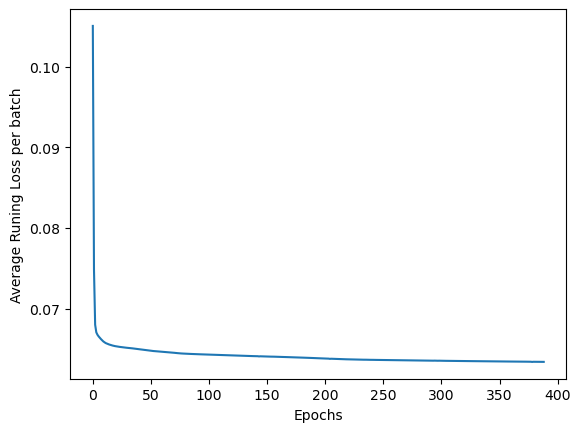

In [23]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [24]:
torch.save(final_model, 'model_100206_single_01.pt')

In [2]:
scan_100307 = process_data.get_nifti_data(config.data_folder2 + '/100307/data.nii.gz')
mask_100307 = process_data.get_nifti_data(config.data_folder2 + '/100307/nodif_brain_mask.nii.gz')

scan_100307_dimension = scan_100307.shape
x = scan_100307_dimension[0]
y = scan_100307_dimension[1]
z = scan_100307_dimension[2]
b = scan_100307_dimension[3]

In [3]:
scan_100307_long = np.reshape(scan_100307, (x*y*z, b))
mask_100307_long = np.reshape(mask_100307, (x*y*z, 1))

In [4]:
indices_beginning_0_all_100307 = np.where(scan_100307_long[:, 0] == 0)[0]

mask_100307_long_pro = np.copy(mask_100307_long)
mask_100307_long_pro[indices_beginning_0_all_100307] = 0

In [5]:
scan_100307_long_no_background = process_data.remove_background(scan_100307_long, mask_100307_long_pro)

In [6]:
bvals_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvals') * 1e-3

In [7]:
S0_100307 = process_data.get_S0(scan_100307_long_no_background, bvals_all_100307)

In [8]:
normalized_scan_100307 = scan_100307_long_no_background / S0_100307

In [9]:
np.save("normalized_scan_100307_full.npy", normalized_scan_100307)

In [10]:
single_normalized_scan_100307 = normalized_scan_100307[:,0:16]

In [11]:
single_bvals_100307 = bvals_all_100307[0:16]

In [12]:
single_big_b_indices_100307 = np.where(single_bvals_100307 != 0.005)[0]

In [13]:
single_normalized_scan_100307_no_b5 = single_normalized_scan_100307[:, single_big_b_indices_100307]
single_bvals_100307_no_5 = single_bvals_100307[single_big_b_indices_100307]

In [19]:
n_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvecs')
single_n_100307 = n_all_100307[:, 0:16]
single_n_100307_no_5 = single_n_100307[:,single_big_b_indices_100307].T
print(single_n_100307_no_5.shape)

single_b_values_100307 = torch.FloatTensor(single_bvals_100307_no_5)
single_gradient_directions_100307 = torch.FloatTensor(single_n_100307_no_5)

(15, 3)


In [20]:
net_100307_single = BallStickNet(single_gradient_directions_100307, single_b_values_100307)
net_100307_single.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ball-stick/model_100206_single_01.pt"))
net_100307_single.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=15, out_features=15, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=15, out_features=15, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=15, out_features=15, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=15, out_features=15, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=15, out_features=5, bias=True)
  )
)

In [25]:
X_100307_single_pred, theta_100307_single_pred, phi_100307_single_pred, mu_cart_100307_single_pred, lambda_par_100307_single_pred, lambda_iso_100307_single_pred,  volume_0_100307_single_pred, volume_1_100307_single_pred = net_100307_single(torch.from_numpy(single_normalized_scan_100307_no_b5.astype(np.float32)))

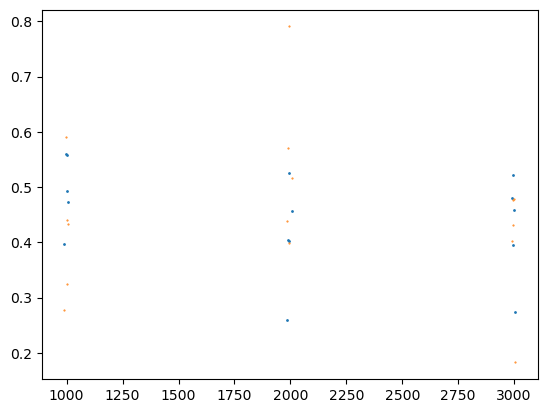

In [26]:
plt.plot(single_bvals_100307_no_5*1e03, X_100307_single_pred[1234,:].detach().numpy(),  "o", markersize = 1)
plt.plot(single_bvals_100307_no_5*1e03,single_normalized_scan_100307_no_b5[1234,:], ".", markersize = 1)

In [23]:
def add_bg(mask_long, params):
    resume_params = np.copy(mask_long)
    no_bg_indices = np.where(mask_long == 1)[0]
    for i, index in enumerate(no_bg_indices):
        resume_params[index] = params[i]
    return resume_params

def back_to_3D(mask_long, parames_1d, shape):
    params_with_bg = add_bg(mask_long, parames_1d.detach().numpy())
    params_3d = np.reshape(params_with_bg, shape)
    return params_3d

In [27]:
lambda_par_100307_pred_3d = back_to_3D(mask_100307_long_pro, lambda_par_100307_single_pred, (145, 174, 145))
lambda_iso_100307_pred_3d = back_to_3D(mask_100307_long_pro, lambda_iso_100307_single_pred, (145, 174, 145))
volume_0_100307_pred_3d = back_to_3D(mask_100307_long_pro, volume_0_100307_single_pred, (145, 174, 145))
volume_1_100307_pred_3d = back_to_3D(mask_100307_long_pro, volume_1_100307_single_pred, (145, 174, 145))

In [28]:
import matplotlib

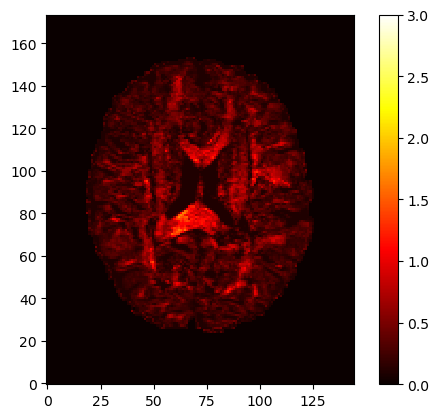

In [29]:
im = plt.imshow(lambda_par_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"], vmin = 0, vmax = 3)
plt.colorbar(im)

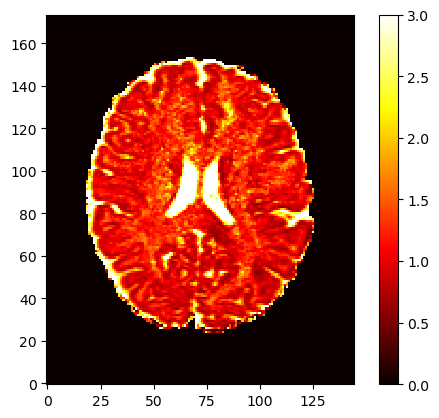

In [30]:
im = plt.imshow(lambda_iso_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

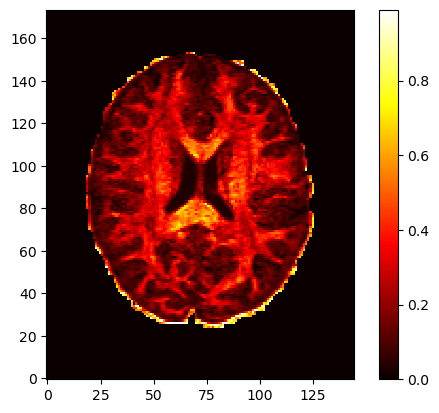

In [31]:
im = plt.imshow(volume_0_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)

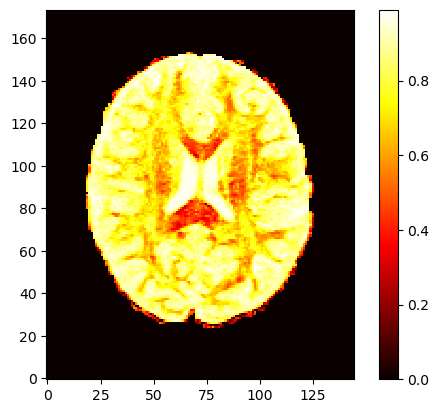

In [32]:
im = plt.imshow(volume_1_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"])
plt.colorbar(im)